In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sinter
from stimbposd import SinterDecoder_BPOSD

from pathlib import Path
import sys
sys.path.append(str(Path("..").resolve()))

from rotated_surface_code import RotatedSurfaceCode
import os


# MWPM

In [ ]:
tasks = []
for d in [3, 5, 7]: # distance
    code = RotatedSurfaceCode(d=d)
    for p in np.arange(0.002, 0.011, 0.002): # physical error rate
        circuit_with_xz_detectors = code.make_circuit_memory_z_experiment(
            rounds=d,
            data_qubit_error_rate=p,
            prep_error_rate=p,
            meas_error_rate=p,
            gate1_error_rate=p,
            gate2_error_rate=p,
            keep_z_detectors_only=False,
        )
        circuit_with_only_z_detectors = code.make_circuit_memory_z_experiment(
            rounds=d,
            data_qubit_error_rate=p,
            prep_error_rate=p,
            meas_error_rate=p,
            gate1_error_rate=p,
            gate2_error_rate=p,
            keep_z_detectors_only=True,
        )
        tasks.append(
            sinter.Task(
                circuit=circuit_with_xz_detectors,
                detector_error_model=circuit_with_xz_detectors.detector_error_model(decompose_errors=True),
                decoder='pymatching',
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': d,
                    'detector_basis': 'X&Z',
                }
            )
        )
        tasks.append(
            sinter.Task(
                circuit=circuit_with_only_z_detectors,
                detector_error_model=circuit_with_only_z_detectors.detector_error_model(decompose_errors=True),
                decoder='pymatching',
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': d,
                    'detector_basis': 'Z',
                }
            )
        )

collected_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    tasks=tasks,
    max_shots=500_000,
    max_errors=50,
    print_progress=True,
)

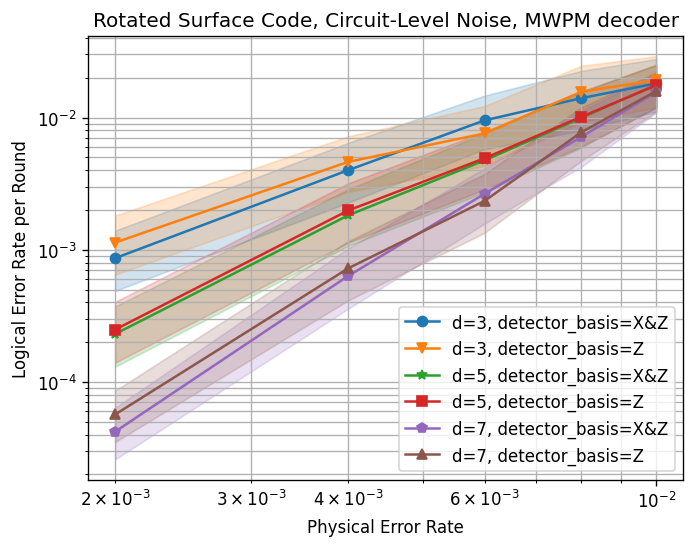

In [3]:
# Plot the error rate vs. physical error rate
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: dict(
        label="d={}, detector_basis={}".format(stats.json_metadata['d'], stats.json_metadata['detector_basis'])
    ),
    failure_units_per_shot_func=lambda stats: stats.json_metadata['r'],
)
ax.loglog()
ax.set_title("Rotated Surface Code, Circuit-Level Noise, MWPM decoder")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

# BP+OSD

In [ ]:
tasks = []
for d in [3, 5]: # distance
    code = RotatedSurfaceCode(d=d)
    for p in np.arange(0.002, 0.011, 0.002): # physical error rate
        circuit_with_xz_detectors = code.make_circuit_memory_z_experiment(
            rounds=d,
            data_qubit_error_rate=p,
            prep_error_rate=p,
            meas_error_rate=p,
            gate1_error_rate=p,
            gate2_error_rate=p,
            keep_z_detectors_only=False,
        )
        circuit_with_only_z_detectors = code.make_circuit_memory_z_experiment(
            rounds=d,
            data_qubit_error_rate=p,
            prep_error_rate=p,
            meas_error_rate=p,
            gate1_error_rate=p,
            gate2_error_rate=p,
            keep_z_detectors_only=True,
        )
        tasks.append(
            sinter.Task(
                circuit=circuit_with_xz_detectors,
                decoder='bposd',
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': d,
                    'detector_basis': 'X&Z',
                }
            )
        )
        tasks.append(
            sinter.Task(
                circuit=circuit_with_only_z_detectors,
                decoder='bposd',
                json_metadata={
                    'p': p,
                    'd': d,
                    'r': d,
                    'detector_basis': 'Z',
                }
            )
        )

collected_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    tasks=tasks,
    custom_decoders={
        'bposd': SinterDecoder_BPOSD()
    },
    max_shots=500_000,
    max_errors=50,
    print_progress=True,
)

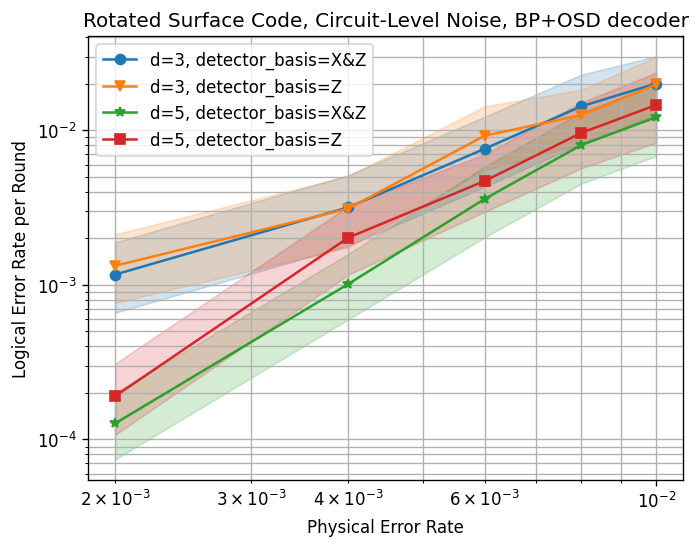

In [5]:
# Plot the error rate vs. physical error rate
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: dict(
        label="d={}, detector_basis={}".format(stats.json_metadata['d'], stats.json_metadata['detector_basis'])
    ),
    failure_units_per_shot_func=lambda stats: stats.json_metadata['r'],
)
ax.loglog()
ax.set_title("Rotated Surface Code, Circuit-Level Noise, BP+OSD decoder")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger